In [8]:
import torch 
import os
import numpy as np
import pandas as pd
import wfdb
from scipy.io import wavfile
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import parselmouth
from parselmouth.praat import call
import librosa
from librosa.util import frame
from librosa.core import frames_to_time
import re

In [9]:
folder = './voice-audios/'

dic_class = {0: 'healthy', 1: 'not healthy', 2: 'unknown'}
dic_class_cat = {'healthy': 0, 'not healthy': 1, 'unknown': 2}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42  
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(seed)
os.environ['SCIPY_ARRAY_API'] = '1'

Using device: cuda


In [10]:
def muestras(nombre_base, fs, canal, c): 
    # Mostrar info
    print(f"\n📁 Archivo: {nombre_base}")
    print(f"🔊 Frecuencia de muestreo: {fs} Hz")
    print(f"📏 Duración: {len(canal) / fs:.2f} segundos")
    print(f"📈 Amplitud (min, max): ({np.min(canal):.4f}, {np.max(canal):.4f})")
    print(f"⚡ RMS: {np.sqrt(np.mean(canal**2)):.4f}")
    print(f" Clase: {c}")

    # Reproducir (IPython)
    display(Audio(canal, rate=int(fs)))

    # Plot
    plt.figure(figsize=(10, 3))
    plt.plot(canal, linewidth=0.8)
    plt.title(f"Señal de voz: {nombre_base}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def clase(diagnostico):
    if 'healthy' in diagnostico:
        return 0
    else: 
        return 1
    
def clasificar_vhi(x):
    if pd.isna(x):      
        return None
    elif x <= 30:
        return 0
    elif x <= 60:
        return 1
    else:
        return 2

def clasificar_rsi(x):
    if pd.isna(x):      
        return None
    elif x <= 13: 
        return 0
    else: 
        return 1
    
def datos(ruta_completa): 
    with open(ruta_completa, 'r') as f:
        for linea in f:
            if ':' not in linea:
                continue
            clave, valor = linea.strip().split(':', 1)
            clave = clave.strip().lower()
            valor = valor.strip()

            if valor in ['NU', '']:
                valor = None
            if clave == 'age':
                edad = int(valor) if valor else None
            elif clave == 'gender':
                genero = valor
            elif clave == 'diagnosis':
                diagnostico = valor
            elif 'vhi' in clave:
                vhi = int(valor) if valor else None
            elif 'rsi' in clave:
                rsi = int(valor) if valor else None
    return edad, genero, diagnostico, vhi, rsi

def obtener_dataset(carpeta, guardar_audio=False, save=False, show_samples=False):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.hea')]
    print(f"Se encontraron {len(archivos)} archivos.")

    data = []

    for i, archivo in enumerate(archivos):
        file_name = os.path.splitext(archivo)[0]
        ruta_completa = os.path.join(carpeta, file_name)
        ruta_info = os.path.join(carpeta, file_name + '-info.txt')

        try:
            record = wfdb.rdrecord(ruta_completa) 
            signal = record.p_signal
            fs = record.fs
            canal = signal[:, 0] 

            canal_norm = canal / np.max(np.abs(canal))  
            canal_int16 = (canal_norm * 32767).astype(np.int16) 

            if guardar_audio:
                ruta_audio = os.path.join(carpeta, f"{file_name}.wav")
                wavfile.write(ruta_audio, int(fs), canal_int16)

            edad, genero, diagnostico, vhi, rsi = datos(ruta_info)
            c = clase(diagnostico)

            if i % 50 == 0 and show_samples:
                muestras(file_name, fs, canal, c)

            data.append({
                'file_name': file_name,
                'sample_rate': fs,
                'waveform': canal,
                'edad': edad,
                'genero': genero,
                'diagnostico': diagnostico,
                'clase': c, 
                'vhi': vhi,
                'rsi': rsi
            })

        except Exception as e:
            print(f"❌ Error al procesar {file_name}: {e}")

    X = pd.DataFrame(data)
    
    print(X['clase'].value_counts())

    X['vhi_score'] = X['vhi'].apply(clasificar_vhi)
    print(X['vhi_score'].value_counts())
    
    X['rsi_score'] = X['rsi'].apply(clasificar_rsi)
    print(X['rsi_score'].value_counts())

    if save:
        nombre_salida = os.path.join(carpeta, "datos_generales.eav")
        X.to_pickle(nombre_salida)
        print(f"✅ Dataset guardado como {nombre_salida}")

    return X


Se encontraron 208 archivos.

📁 Archivo: voice001
🔊 Frecuencia de muestreo: 8000 Hz
📏 Duración: 4.76 segundos
📈 Amplitud (min, max): (-0.4626, 0.5901)
⚡ RMS: 0.1302
 Clase: 1


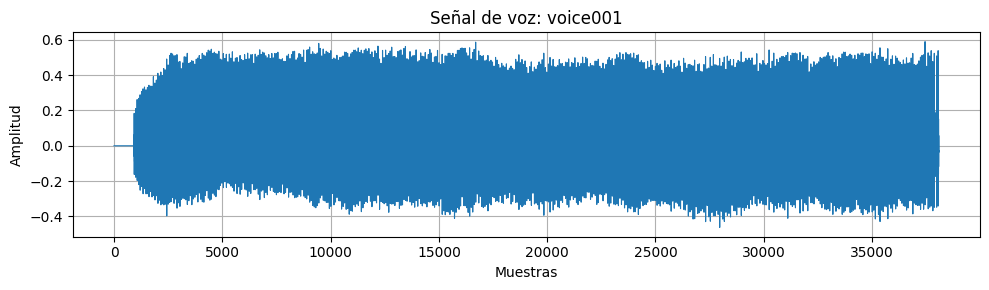


📁 Archivo: voice051
🔊 Frecuencia de muestreo: 8000 Hz
📏 Duración: 4.72 segundos
📈 Amplitud (min, max): (-0.2992, 0.5498)
⚡ RMS: 0.1313
 Clase: 0


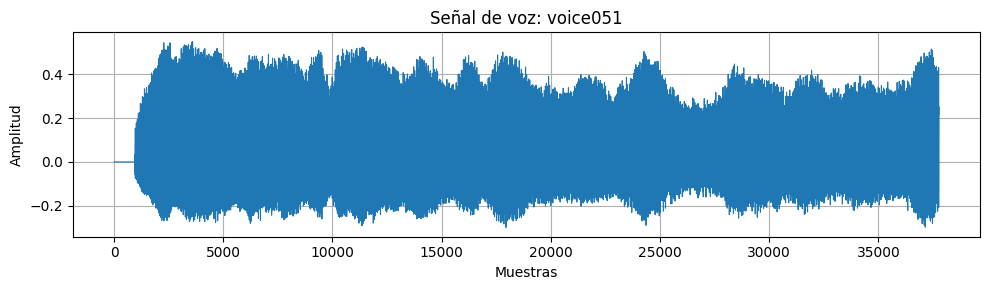


📁 Archivo: voice101
🔊 Frecuencia de muestreo: 8000 Hz
📏 Duración: 4.76 segundos
📈 Amplitud (min, max): (-0.9183, 0.9719)
⚡ RMS: 0.2596
 Clase: 0


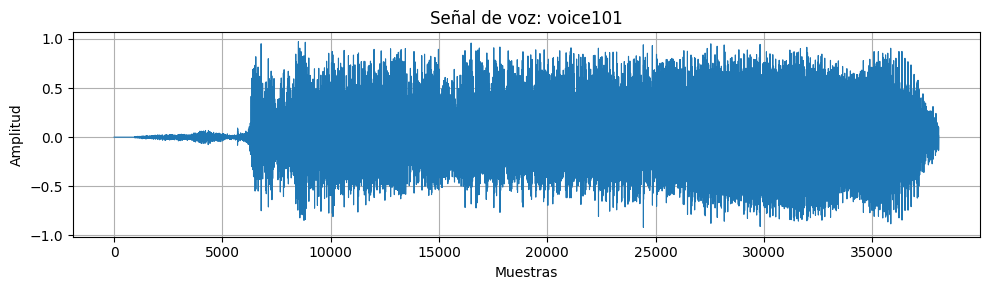


📁 Archivo: voice151
🔊 Frecuencia de muestreo: 8000 Hz
📏 Duración: 4.76 segundos
📈 Amplitud (min, max): (-0.7551, 0.8871)
⚡ RMS: 0.2723
 Clase: 1


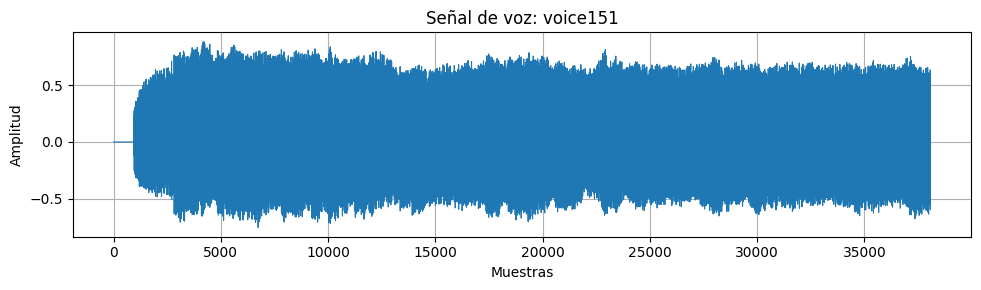


📁 Archivo: voice201
🔊 Frecuencia de muestreo: 8000 Hz
📏 Duración: 4.76 segundos
📈 Amplitud (min, max): (-0.7343, 0.9626)
⚡ RMS: 0.2019
 Clase: 1


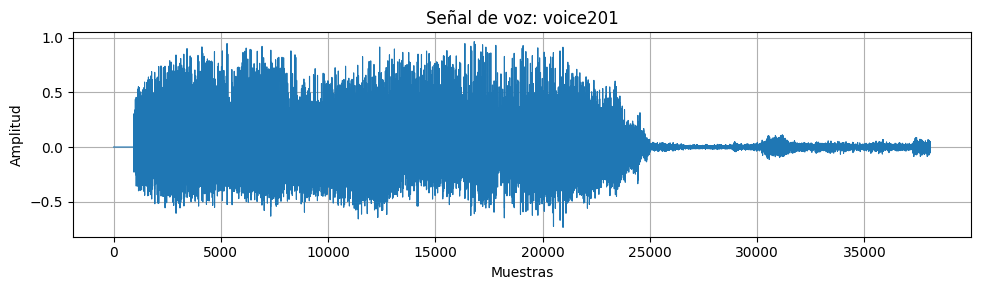

clase
1    151
0     57
Name: count, dtype: int64
vhi_score
0    145
1     43
2     20
Name: count, dtype: int64
rsi_score
0    121
1     87
Name: count, dtype: int64
✅ Dataset guardado como ./voice-audios/datos_generales.eav


In [11]:
X = obtener_dataset(folder, guardar_audio=False, save=True, show_samples=True)


In [ ]:
def intensidad(canal, fs, plot = False):
    win_length = int(0.04 * fs)  # 40ms
    hop_length = int(0.01 * fs)  # 10ms

    X = frame(canal, frame_length=win_length, hop_length=hop_length)
    tf = frames_to_time(np.arange(X.shape[1]), sr=fs, hop_length=hop_length)
    I = (X**2).sum(0)
    I_db = 10 * np.log10(I + 1e-10)

    if plot: 
        plt.figure(figsize=(12, 4))
        plt.plot(tf, I_db)
        plt.title('Energía en el tiempo')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Energía (dB)')
        plt.grid()
        plt.show()
    
    return tf, I_db

def pitch(canal, fs, plot=False):
    if plot:
        win_length = int(0.04 * fs)
        hop_length = int(0.01 * fs)

        X = frame(canal, frame_length=win_length, hop_length=hop_length)
        tf = frames_to_time(np.arange(X.shape[1]), sr=fs, hop_length=hop_length)

        # Autocorrelación por ventana
        acf = np.fft.irfft(np.abs(np.fft.rfft(X, axis=0)), axis=0).real
        acf = acf / np.max(acf, axis=0)
        acf = acf[:acf.shape[0] // 2, :]

        periodo = win_length / fs

        plt.figure(figsize=(12, 4))
        plt.imshow(acf, extent=(0, tf[-1], 0, periodo), aspect='auto', origin='lower')
        plt.colorbar(label='Valor de autocorrelación')

    # Estimación de pitch con pyin
    f0, _, _ = librosa.pyin(
        y=canal,
        sr=fs,
        fmin=librosa.note_to_hz('C2'),  # ≈ 65.4 Hz
        fmax=librosa.note_to_hz('C6')   # ≈ 1046.5 Hz
    )
    times = librosa.times_like(f0, sr=fs)

    # Calcular el periodo de forma segura
    res = np.zeros_like(f0)
    mask = ~np.isnan(f0) & (f0 > 0)
    res[mask] = 1 / f0[mask]

    if plot:
        plt.plot(times[mask], res[mask], label='Periodo estimado (1/f0)', color='r')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Periodo (s)')
        plt.title('Autocorrelación + Pitch')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return times, res

def pitch_difference(f0):
    f0_clean = f0[~np.isnan(f0)]
    if len(f0_clean) == 0:
        return np.nan  
    return np.max(f0_clean) - np.min(f0_clean)

def jitter_shimmer_HNR(canal, fs, plot = False):
    # Crear objeto parselmouth
    snd = parselmouth.Sound(canal, sampling_frequency=fs)

    # Parámetros de framing
    frame_length = 0.1  # en segundos
    hop_length = 0.01   # en segundos

    # Generar ventanas temporales
    data = []
    t1s = np.arange(0, snd.duration - frame_length, hop_length)
    times = zip(t1s, t1s + frame_length)
    index = []

    for t1, t2 in times:
        snd_ = snd.extract_part(t1, t2)
        pitch = snd_.to_pitch()
        pp = call(pitch, "To PointProcess")
        vr = call([snd_, pitch, pp], "Voice report", 0, 0, 75, 500, 1.3, 1.6, 0.03, 0.45)
        
        # Parsear voice report
        atributos = dict(re.findall("(.*): (.*)", vr.replace('   ', ''))[1:])
        data.append(atributos)
        index.append((t1 + t2) / 2)  # centro de la ventana

    # Convertir a DataFrame
    df = pd.DataFrame(data, index=index)

    # Limpiar strings y convertir a float
    pattern = re.compile(r" |\%|\(")
    df = df.map(lambda x: float(pattern.split(x)[0]) if 'undefined' not in x else np.nan)

    if plot: 
        print("Atributos calculados:")
        print(df.columns.tolist())

        # Gráficos
        tx = np.arange(len(canal)) / fs  # tiempo total
        fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
        axs[0].plot(tx, canal, label='Forma de onda')
        axs[0].set_title("Forma de onda")
        axs[0].set_ylabel("Amplitud")

        # Atributos acústicos
        atributos_a_graficar = ['Jitter (local)', 'Shimmer (local)', 'Mean harmonics-to-noise ratio']
        for i, feat in enumerate(atributos_a_graficar):
            axs[i+1].plot(df.index, df[feat], label=feat)
            axs[i+1].set_title(feat)
            axs[i+1].set_ylabel('Valor')

        axs[-1].set_xlabel("Tiempo (s)")
        plt.tight_layout()
        plt.show()

        # Audio en Jupyter (opcional)
        display(Audio(canal, rate=fs))
        # Cálculo resumen para análisis vocal
    
    # Cálculo resumen
    resumen_dict = {
        'Jitter (local) mean': df['Jitter (local)'].mean(),
        'Jitter (local) std': df['Jitter (local)'].std(),
        'Shimmer (local) mean': df['Shimmer (local)'].mean(),
        'Shimmer (local) std': df['Shimmer (local)'].std(),
        'HNR mean': df['Mean harmonics-to-noise ratio'].mean(),
        'HNR std': df['Mean harmonics-to-noise ratio'].std()
    }

    resumen_df = pd.DataFrame([resumen_dict])

    return df, resumen_df   

def melspectrogram(canal, fs, n_fft=512, hop_length=None,  n_mels=64, plot = False):
    if hop_length is None:
        hop_length = n_fft // 4

    M = librosa.feature.melspectrogram(y=canal, sr=fs, n_fft=n_fft,
                                    hop_length=hop_length, n_mels=n_mels)

    M_db = librosa.power_to_db(M, ref=np.max)

    if plot: 
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(M_db, sr=fs, x_axis='time', y_axis='linear',
                                hop_length=hop_length)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Melspectrograma')
        plt.tight_layout()
        plt.show()

    return M_db

def calcular_mfcc(canal, fs, n_mfcc=13, n_fft=512, hop_length=None, plot=False):
    if hop_length is None:
        hop_length = n_fft // 4

    # Normalizar audio si hace falta
    canal = canal.astype(np.float32)

    # Calcular MFCCs
    mfccs = librosa.feature.mfcc(y=canal, sr=fs, n_mfcc=n_mfcc,
                                 n_fft=n_fft, hop_length=hop_length)

    mfcc_resumen = librosa.feature.mfcc(y=canal, sr=fs, n_mfcc=n_mfcc, n_fft=len(canal), n_mels=128, dct_type=2, norm='ortho', center=False)

    if plot:
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(mfccs, x_axis='time', sr=fs, hop_length=hop_length, cmap='viridis')
        plt.colorbar()
        plt.title('MFCC')
        plt.ylabel('Coeficiente')
        plt.tight_layout()
        plt.show()

        mfccs_norm = mfccs-np.mean(mfccs, axis=1, keepdims=True)
        mfccs_norm = mfccs/np.std(mfccs, axis=1, keepdims=True)

        librosa.display.specshow(mfccs_norm, sr=fs, x_axis='time', hop_length=hop_length);
        plt.colorbar()
        plt.title('MFCC normalizado')
        plt.tight_layout()
        plt.show()

    # Convertir a DataFrame
    tiempos = librosa.frames_to_time(np.arange(mfccs.shape[1]), sr=fs, hop_length=hop_length)
    nombres_columnas = [f'MFCC_{i+1}' for i in range(n_mfcc)]
    df_mfcc = pd.DataFrame(mfccs.T, index=tiempos, columns=nombres_columnas)

    return df_mfcc, mfcc_resumen

def formantes(x, sr, orden=8, graficar=False):
    vocal = x - np.mean(x)

    a = librosa.lpc(vocal, order=orden)
    polos = np.roots(a)
    polos = [p for p in polos if np.abs(p) < 1 and np.imag(p) > 0]
    angulos = np.angle(polos)
    magnitudes = np.abs(polos)

    frecuencias = angulos * (sr / (2 * np.pi))
    anchos_banda = -1 * np.log(magnitudes) * (sr / np.pi)
    
    # 6. Crear la lista de formantes y ordenarla por frecuencia
    formantes = sorted(zip(frecuencias, anchos_banda), key=lambda x: x[0])
    
    if graficar:
        # Gráfico 1: Respuesta en frecuencia del filtro LPC
        w, h = freqz([1], a, worN=2048, fs=sr)
        plt.figure(figsize=(10, 5))
        plt.plot(w, 20 * np.log10(abs(h)))
        plt.title('Respuesta en Frecuencia del Filtro LPC (Tracto Vocal)')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud (dB)')
        plt.grid(True)
        # Marcar las formantes encontradas
        for f, bw in formantes:
            plt.axvline(f, color='r', linestyle='--', alpha=0.8)
            plt.text(f + 50, -5, f'{f:.0f} Hz', rotation=90, color='r', va='bottom')
        plt.xlim(0, sr / 2)
        plt.tight_layout()
        plt.show()


    return formantes

def extraer_features(df, n_formantes=3, n_mfcc=13, save=False):

    features = []
    for indice_file, row in df.iterrows():
        file_name = row['file_name']
        print(f'{indice_file+1}. Extrayendo features de {file_name}')
        sample_rate = row['sample_rate']
        waveform = row['waveform']

        waveform = np.array(waveform)   
        fila = {}
        fila['file_name'] = file_name

        # Intensidad
        _, I_db = intensidad(waveform, sample_rate)
        fila['intensidad_mean'] = np.nanmean(I_db)
        fila['intensidad_std'] = np.nanstd(I_db)

        # Pitch
        try:
            _, pitch_array = pitch(waveform, sample_rate)
            fila['pitch_mean'] = np.nanmean(pitch_array)
            fila['pitch_std'] = np.nanstd(pitch_array)
            fila['pitch_diff'] = pitch_difference(pitch_array)
        except:
            fila['pitch_mean'] = np.nan
            fila['pitch_std'] = np.nan

        # Jitter, Shimmer, HNR
        try:
            _, resumen = jitter_shimmer_HNR(waveform, sample_rate)
            for col in resumen.columns:
                fila[col] = resumen[col].values[0]
        except:
            for key in ['Jitter (local) mean', 'Jitter (local) std',
                        'Shimmer (local) mean', 'Shimmer (local) std',
                        'HNR mean', 'HNR std']:
                fila[key] = np.nan

        # MFCC
        try:
            df_mfcc, _ = calcular_mfcc(waveform, sample_rate, n_mfcc=n_mfcc)
            for i in range(n_mfcc):
                fila[f'MFCC_{i+1}_mean'] = df_mfcc[f'MFCC_{i+1}'].mean()
        except:
            for i in range(n_mfcc):
                fila[f'MFCC_{i+1}_mean'] = np.nan

        try:
            form = formantes(waveform, sample_rate)
            for j, (freq, bw) in enumerate(form[:n_formantes]):
                fila[f'Formant{j+1}_freq'] = freq
                fila[f'Formant{j+1}_bw'] = bw
        except:
            for j in range(n_formantes):
                fila[f'Formant{j+1}_freq'] = np.nan
                fila[f'Formant{j+1}_bw'] = np.nan

        features.append(fila)

    df_features = pd.DataFrame(features)

    if save: 
        nombre_salida = os.path.join(folder, "features.eav")
        df_features.to_pickle(nombre_salida)
        print(f"✅ Dataset guardado como {nombre_salida}")
        
    return df_features


In [31]:
features = extraer_features(X, save=True)

1. Extrayendo features de voice001
2. Extrayendo features de voice002
3. Extrayendo features de voice003
4. Extrayendo features de voice004
5. Extrayendo features de voice005
6. Extrayendo features de voice006
7. Extrayendo features de voice007
8. Extrayendo features de voice008
9. Extrayendo features de voice009
10. Extrayendo features de voice010
11. Extrayendo features de voice011
12. Extrayendo features de voice012
13. Extrayendo features de voice013
14. Extrayendo features de voice014
15. Extrayendo features de voice015
16. Extrayendo features de voice016
17. Extrayendo features de voice017
18. Extrayendo features de voice018
19. Extrayendo features de voice019
20. Extrayendo features de voice020
21. Extrayendo features de voice021
22. Extrayendo features de voice022
23. Extrayendo features de voice023
24. Extrayendo features de voice024
25. Extrayendo features de voice025
26. Extrayendo features de voice026
27. Extrayendo features de voice027
28. Extrayendo features de voice028
2

In [33]:
X.head()

,file_name,sample_rate,waveform,edad,genero,diagnostico,clase,vhi,rsi,vhi_score,rsi_score
0,voice001,8000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",32,m,hyperkinetic dysphonia,1,15,5,0,0
1,voice002,8000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",55,m,healthy,0,17,12,0,0
2,voice003,8000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",34,m,hyperkinetic dysphonia (nodule),1,42,26,1,1
3,voice004,8000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,f,hypokinetic dysphonia,1,20,9,0,0
4,voice005,8000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,f,hypokinetic dysphonia,1,39,23,1,1


In [32]:
features.head()

,file_name,intensidad_mean,intensidad_std,pitch_mean,pitch_std,pitch_diff,Jitter (local) mean,Jitter (local) std,Shimmer (local) mean,Shimmer (local) std,...,MFCC_10_mean,MFCC_11_mean,MFCC_12_mean,MFCC_13_mean,Formant1_freq,Formant1_bw,Formant2_freq,Formant2_bw,Formant3_freq,Formant3_bw
0,voice001,5.494447,13.896660,0.008854,0.000159,0.000609,0.205041,0.088938,9.070939,5.744920,...,-33.485462,-3.193178,-6.094925,-7.690520,731.874084,210.197684,1289.212828,128.167227,2470.237400,103.943774
1,voice002,12.357157,14.790251,0.007779,0.000035,0.000179,0.077475,0.037627,2.556322,1.601929,...,-30.699730,-24.061018,-15.156450,-4.892391,655.359528,131.581387,1158.020064,128.984435,2485.505181,238.856883
2,voice003,11.421944,14.656618,0.006956,0.000034,0.000161,0.086406,0.031139,4.244061,1.941773,...,-33.882381,-13.012620,-0.145573,-9.267430,635.978532,246.399527,1176.832423,282.342458,2614.393379,936.034069
3,voice004,-2.615702,12.918973,0.005220,0.000059,0.000240,0.106184,0.052703,9.310892,4.337339,...,-4.257187,-25.908045,-10.753979,-24.885277,216.046567,389.106703,1208.283386,774.274271,1637.102578,222.716206
4,voice005,8.338069,14.402722,0.006021,0.000702,0.006174,0.136829,0.080103,4.279963,1.847730,...,2.413004,-15.160659,-0.391818,-24.341862,955.279688,118.238329,1431.717061,429.580252,3121.411993,294.565483
